In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats
from scipy import stats
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.stattools import omni_normtest

from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.api import qqplot, add_constant

from sklearn.preprocessing import scale, minmax_scale, robust_scale

%matplotlib inline
sns.set(font="AppleGothic")
plt.rcParams['axes.unicode_minus']=False

# 1. 데이터 속성 및 기술통계량 확인 

In [10]:
df = pd.read_csv('titanic.csv', engine='python', encoding='cp949')
df.head(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# 1-1. 데이터 속성: 범주형 변수와 연속형 변수 확인
Name, Sex, Ticket은 범주형 변수이다.
추가적으로 Pclass, SibSp, Parch, Survied는 실수형이지만 범주형 변수이다.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# 1-2. 기술통계량
승객 나이 평균은 약 30세이다.

요금 평균은 32파운드이다.

In [3]:
df.drop('PassengerId', axis=1).describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.758889,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002570,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 2. 목표변수 및 설명변수(범주형/연속형)의 분포 확인

# 2-1. 범주형 변수들

# 설명변수1: 좌석 등급의 count
3등급 좌석이 가장 많고 순서는 3등급>1등급>2등급이다.

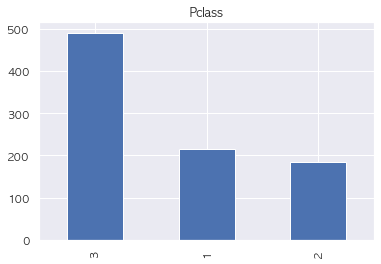

In [28]:
df_cnt= df['Pclass'].value_counts()
df_cnt.plot.bar()
plt.title('Pclass')
plt.show()
plt.close()

<AxesSubplot:xlabel='Pclass', ylabel='count'>

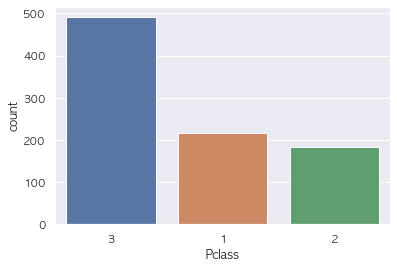

In [16]:
sns.countplot(x='Pclass', data=df, order=df['Pclass'].value_counts().index)

# 설명변수2: 성별 count

남성이 여성보다 2배 많다

<AxesSubplot:xlabel='Sex', ylabel='count'>

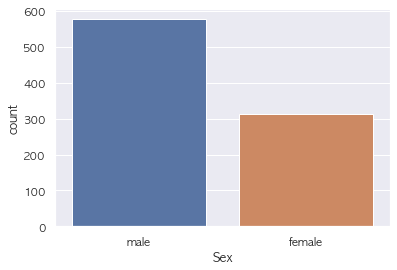

In [7]:
sns.countplot(x='Sex', data=df, order=df['Sex'].value_counts().index)

# 성별 변수 히스토그램 겹처 그리어 해석하기.
두 성별의 분포를 비교하기 위해서 히스토그램의 범위를 동일하게 설정하고 겹쳐 그리는 방법을 사용했다.

결과: 

두 성별 모두 30을 평균으로 가지는 분포를 가지며, 나이범위에 따른 승객 분포가 비슷함을 알 수 있다.

남, 녀 모두 20대 이상이 대다수를 차지한다.

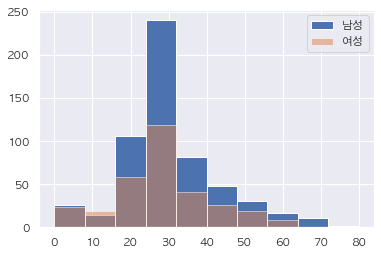

In [15]:
plt.hist(df[df['Sex']=='male']['Age'], label='남성', alpha=1, range=(0,80))
plt.hist(df[df['Sex']=='female']['Age'], label='여성', alpha=0.5, range=(0,80))
plt.legend()
plt.ylabel('Count')
plt.xlabel('Sex')
plt.show()

# 설명변수 3, 4: SibSp, Parch

함께 탑승한 형제, 배우자, 자녀, 부모의 수는 대부분 0명이다.

=>따라서 아마도 종속 변수에 대한 설명력이 적을 것으로 예상된다.

분포는 skewed 분포를 띄고 있다.

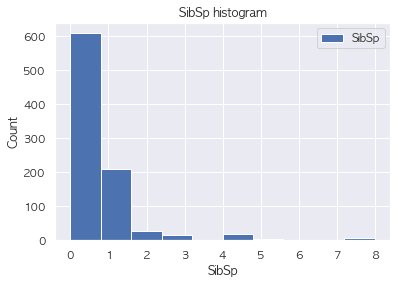

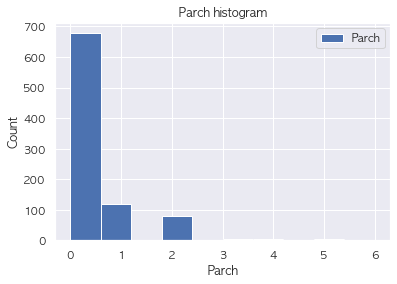

In [70]:
labels=['SibSp','Parch']
for label in labels:
#     sns.countplot(x=label, data=df, order=df[label].value_counts().index)
#     plt.show()
#     plt.close()
    plt.hist(df[label], label=label, alpha=1)#, range=(0,80))
    plt.legend()
    plt.title(label+' histogram')
    plt.ylabel('Count')
    plt.xlabel(label)
    plt.show()
    plt.close()

# 2-2. 연속형 변수들

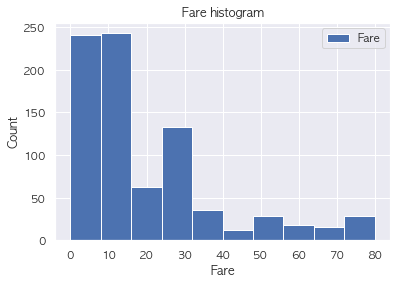

In [4]:
labels=['Fare']
for label in labels:

    plt.hist(df[label], label=label, range=(0,80))
    plt.legend()
    plt.title(label+' histogram')
    plt.ylabel('Count')
    plt.xlabel(label)
    plt.show()
    plt.close()

# 3. 변수들의 결측 및 이상치 처리
- Cabin(객실 번호)에 600개 이상의 결측치가 있다.
- 결측치 처리 방법 고안: 
    - 데이터의 대다수(77.1%)가 결측되어있으므로 Cabin 변수가 종속 변수에 영향을 미치치 않는다고 가정하고 분석에서 제외하는 것으로 결정하였다.

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Cabin        204 non-null    object 
 9   Agegroup     891 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 69.7+ KB


# 4. 변수간 관계 확인
### 종속 변수가 이산형이므로 변수간 상관 관계 확인을 위해 연속형 변수로 파생 변수를 만들었습니다

# 4-0. 파생 변수 생성1: 나이그룹
나이대에 따른 영향력을 해석하기 위해, age_categorize함수를 정의하고 Age변수에 적용하여 Agegroup변수를 새롭게 만들었습니다.

In [12]:
# 숫자형 데이터를 범주형으로 변환
import math
def age_categorize(age):
    if math.isnan(age):
        return -1
    return math.floor(age/10)*10  

df['Agegroup']=df['Age'].apply(age_categorize)

# 4-1. 파생 변수 생성2: 생존률
survived 변수에서 생존은 1이고 생존하지 못한 것은 0으로 표시되므로,

생존률은 다음과 같이 정의된다.

**그룹별 생존률 = 그룹 내부 survived 변수의 총 합/ 그룹 내부 survived 변수의 총 개수**


In [14]:
# 그룹화
class_group = df.groupby('Pclass') # Pclass 기준으로 그룹화
gender_group = df.groupby('Sex') # Sex 기준으로 그룹화
age_group = df.groupby('Agegroup') # Agegroup 기준으로 그룹화
SibSp_group = df.groupby('SibSp') # SibSp 기준으로 그룹화
Parch_group = df.groupby('Parch') # Parch 기준으로 그룹화
Fare_group = df.groupby('Fare') # Fare 기준으로 그룹화

In [15]:
surv_ratio_class = class_group.mean()['Survived'].sort_values(ascending=False)
surv_ratio_gender = gender_group.mean()['Survived'].sort_values(ascending=False)
surv_ratio_age = age_group.mean()['Survived'].sort_values(ascending=False)
surv_ratio_SibSp = SibSp_group.mean()['Survived'].sort_values(ascending=False)
surv_ratio_Parch = Parch_group.mean()['Survived'].sort_values(ascending=False)
Fare_ratio_Parch = Fare_group.mean()['Survived'].sort_values(ascending=False)

# 📌해석: 설명변수에 따른 생존률
## 그에 따른 가설 설정
- 승객 등급(좌석 등급)이 높을수록 생존률이 높다. 
    - =>대립가설(H1): Pclass와 생존률과 상관관계가 있다.


- 여성이 남성보다 생존률이 월등히 높다.
    - =>대립가설(H1):  Sex와 생존률과 상관관계가 있다.


- 나이가 매우 많거나 적은 순서대로 생존률이 높다. 20, 30대의 생존률은 상대적으로 낮다.
    - =>대립가설(H1):  Age와 생존률과 상관관계가 있다.


- 형제, 배우자 수가 3명 이상인 경우 생존률이 30%이하로 낮다.
- 함께 탑승한 자녀, 부모의 수가 3명 이하인 경우 생존률이 50%이상으로 높다.

    - =>대립가설(H1):  SibSp와 Parch가 생존률과 상관관계가 있다.

====================설명변수 그룹에 따른 생존률====================
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


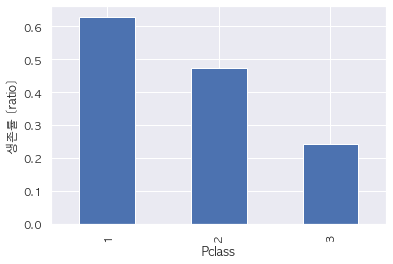

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


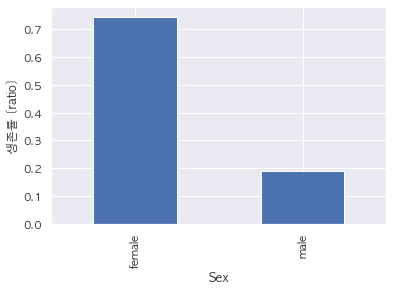

Agegroup
80    1.000000
0     0.612903
50    0.416667
10    0.401961
40    0.382022
30    0.363372
20    0.350000
60    0.315789
70    0.000000
Name: Survived, dtype: float64


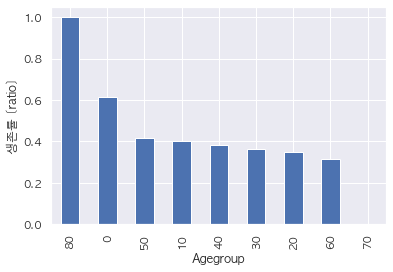

SibSp
1    0.535885
2    0.464286
0    0.345395
3    0.250000
4    0.166667
8    0.000000
5    0.000000
Name: Survived, dtype: float64


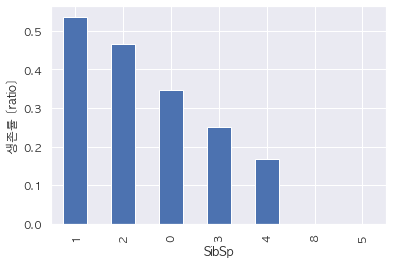

Parch
3    0.600000
1    0.550847
2    0.500000
0    0.343658
5    0.200000
6    0.000000
4    0.000000
Name: Survived, dtype: float64


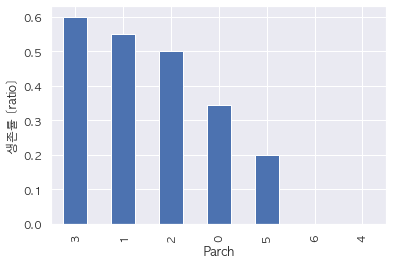

In [155]:
print('='*20+'설명변수 그룹에 따른 생존률'+'='*20)
for g in [surv_ratio_class, surv_ratio_gender, surv_ratio_age, surv_ratio_SibSp, surv_ratio_Parch]:
    print(g)
    g.plot.bar()
    plt.ylabel('생존률 [ratio]')
    plt.show()
    plt.close()
    print('='*40)

# 4-2. 산포도와 pearson 상관계수 분석을 통한 연속형 변수의 상관관계 가설 검증
## 📌해석

### Age와 생존률의 관계: 
- p-value가 0.89으로 H0 채택=>나이와 생존률의 상관관계가 없다.
    - 상관계수: 0.06, p-value: 0.89
    - 이러한 결과가 나온 이유를 산포도를 보고 알 수 있었다.
        - 나이가 10이하로 적으면 생존률이 높아지지만, 나이가 50이상으로 많으면 생존률이 낮아진다. 
        - 80대 100% 생존률을 보이는 데이터는 이상치일 것으로 생각된다.
            - 이상치를 제거하면 상관계수가 커질 것으로 예상된다.

### Fare와 생존률의 관계:
- p-value가 0으로 H0 기각=>티켓요금과 생존률은 양의 상관 관계를 가진다.
    - 상관계수: 0.29, p-value: 0

corr=0.05596479440169938, p-value=0.8862866108446309


/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


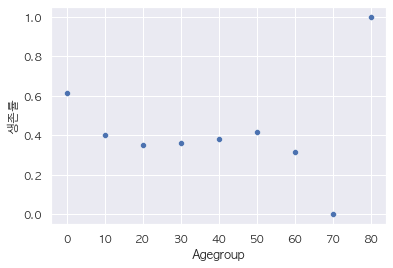

In [18]:
### 나이와 생존률
data = age_group.mean()[['Survived']]
sns.scatterplot(data.index.values.tolist(), y=data['Survived'].tolist())#, hue='Agegroup', style='Agegroup', data=data)
plt.xlabel('Agegroup')
plt.ylabel('생존률')
corr, p = stats.pearsonr(data.index.values.tolist(),data['Survived'].tolist())
print('corr={}, p-value={}'.format(corr, p))

corr=0.2904323218401933, p-value=3.2989155352564168e-06


/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


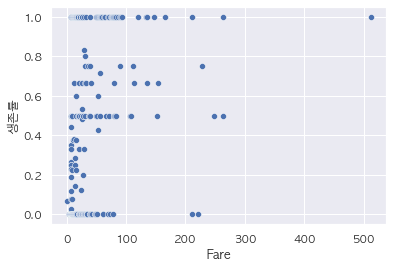

In [16]:
### Fare와 생존률
data = Fare_group.mean()[['Survived']]
sns.scatterplot(data.index.values.tolist(), y=data['Survived'].tolist())#, hue='Agegroup', style='Agegroup', data=data)
plt.xlabel('Fare')
plt.ylabel('생존률')
corr, p = stats.pearsonr(data.index.values.tolist(),data['Survived'].tolist())
print('corr={}, p-value={}'.format(corr, p))

# 5. 생존에 영향을 미치는 잠재 인자

### 범주형 변수는 설명변수 그룹에 따른 생존률 히스토그램 분석,
### 연속형 변수는 산포도와 pearson 상관계수 분석을 진행한 결과,

### 📌Pclass, Age, SibSp, Parch, Fare가 생존 여부 변수에 영향을 미치는 잠재 인자인 것으로 해석했습니다.